# Goal: predict whether a loan will end up with maximum profits or not

---
#### Target variable: `zeroBalCode` 
* Type: **Categorical** 
* Model type: Classification 
* Sourced from: `zeroBalCode`
* Data: 
    - "0" means "Successful outcome for Fannie Mae"
    - "1" means "Negative outcome for Fannie Mae"
    
#### This Notebook:
* Input required: The output files from "Scott - Data Pre - 2 - 50 50 split train test" notebook
    - ../data/DataPre-2-5050-split-2011-test.csv
* Outputs generated: Decision on what model to use

#### Expected Workflow
1. Scott - Data Pre - 1 - Feature EEE
2. Scott - Data Pre - 2 - 50 50 split train test
3. Scott - Model - 1- PyCaret Setup and Create Model
4. Scott - Predict - 1 - Holdout Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.classification import *
#!pip install pycaret

from sklearn.feature_selection import VarianceThreshold

import winsound

# Tell Jupyter to display all text, not just "the last" and print()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%pwd

def DoneNotice(duration_ms = 1000):
    duration = duration_ms  # milliseconds
    freq = 440  #Hz
    winsound.Beep(freq, duration)

from IPython.display import Markdown, display
def Important(html_tag, message, color):
    colorstr = f"<{html_tag} style='color:{color}'>{message}</{html_tag}>"
    display(Markdown(colorstr))

# Importing the data

In [2]:
df = pd.read_csv("../data/DataPre-2-5050-split-2010-test.csv")

# Remove the weird unnamed column
df.drop(['Unnamed: 0'], 1, inplace=True)

print(df.shape)

df.sample(5)

(27888, 12)


,origChannel,origIntRate,origUPB,origLTV,numBorrowers,origDebtIncRatio,loanPurp,worstCreditScore,bankNumber,stateNumber,mSA,zeroBalCode
4578,1,4.500,213000,57,1,30,1,695,54,4,41860,0
19471,3,4.500,112000,69,1,35,2,805,45,6,35300,1
13769,3,4.875,288000,80,1,33,2,795,45,20,44140,0
18285,1,5.875,107000,77,2,40,2,634,80,51,11540,1
6574,3,5.250,100000,40,1,42,1,754,4,23,19820,1


# Pycaret - Setup with categorical definition

#### Normalization
https://pycaret.org/normalization/

> `normalize: bool, default = False` - When set to True, the feature space is transformed using the normalized_method param. **Generally, linear algorithms perform better with normalized data** however, the results may vary and it is advised to run multiple experiments to evaluate the benefit of normalization.

In [4]:
%%time

model_setup = setup(
    df
    , target = 'zeroBalCode' # PyCaret will list this as "Label"
    , pca = False 
    # , ignore_low_variance = True # Variance is calculated using the ratio of unique values to the number of samples, and the ratio of the most common value to the frequency of the second most common value.
    , normalize = True
    , ignore_features = None
    # , remove_outliers = True # outliers from the training data are removed using PCA linear dimensionality reduction using the Singular Value Decomposition technique.
    , silent = True
    , profile = False
    , categorical_features = [
            'origChannel'
            , 'loanPurp'
            , 'bankNumber'
            , 'stateNumber'
            , 'mSA'
        ]
    , numeric_features = [
        'origIntRate'
        , 'origUPB'
        , 'origLTV'
        , 'numBorrowers'
        , 'origDebtIncRatio'
        , 'worstCreditScore'
    ]
)

DoneNotice(2000)

Important("h1", "PyCaret setup completed", 'blue')

# session_id - if you ever want to reprint the results later, pass the session_id to setup()
#      and it will run the setup using the same split of test/train

 
Setup Succesfully Completed!


,Description,Value
0,session_id,3674
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(27888, 12)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


<h1 style='color:blue'>PyCaret setup completed</h1>

Wall time: 49.9 s


# Decide which model to use

In [5]:
%%time

# Can influence performance by reducing # of folds (10 is def.) or adding blacklists/exclusions
# Regression has about 21 models
# Classification has about 15 models
# Logistic Regression - ‘lr’
# K Nearest Neighbour - ‘knn’
# Naives Bayes - ‘nb’
# Decision Tree - ‘dt’
# SVM (Linear) - ‘svm’
# Gaussian Process - ‘gpc’
# Ridge Classifier - ‘ridge’
# Random Forest - ‘rf’
# Quadratic Disc. Analysis - ‘qda’
# AdaBoost - ‘ada’
# Linear Disc. Analysis - ‘lda’
# Extra Trees Classifier - ‘et’
# Extreme Gradient Boosting - ‘xgboost’
# Light Gradient Boosting - ‘lightgbm’
# Cat Boost Classifier - ‘catboost’
####### Off by default (enable w "turbo = False")
# Multi Level Perceptron - ‘mlp’
# Gradient Boosting Classifier - ‘gbc’
# SVM (RBF) - ‘rbfsvm’
# 
# compare_models(blacklist=['catboost', 'xgboost', 'lightgbm'])
# 
# Slow: 
#    - Gaussian Process Classifier
#    - 

model_results=compare_models(
    fold=10
    , blacklist = [
            'ada'
            , 'knn'
            , 'lda'
            , 'lr'
            , 'nb'
            , 'svm'
            , 'qda'
            , 'rf'
            , 'ridge'
            , 'gbc'  # let xgboost and lightgbm 
        ] 
    ,  round = 4 # number of decimal places to round to. 4 is default
    ,  sort = 'Recall'
    , turbo = True # True by default. Auto blacklists models that have longer training times. When True, rbfsvm, gpc and mlp are excluded due to longer training times. If you set to False, could take a long time
)
model_results

DoneNotice(2000)

Wall time: 5min 42s


In [5]:
%%time 

# Extra Trees Classifier has best balance
et = create_model(
    'et'
    , ensemble = False
    , method = None # if ensemble, choose 'Bagging' or 'Boosting'
    , fold = 2
    , round = 4 # decimal places
    , verbose = True
)

DoneNotice(2000)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9189,0.9711,0.9267,0.9125,0.9195,0.8378
1,0.9244,0.9777,0.9297,0.9199,0.9248,0.8487
Mean,0.9216,0.9744,0.9282,0.9162,0.9222,0.8433
SD,0.0027,0.0033,0.0015,0.0037,0.0026,0.0055


In [7]:
%%time

# Extra Trees Classifier has best balance
et20 = create_model(
    'et'
    , ensemble = False
    , method = None # if ensemble, choose 'Bagging' or 'Boosting'
    , fold = 20
    , round = 4 # decimal places
    , verbose = True
)

DoneNotice(2000)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9027,0.9682,0.9044,0.9014,0.9029,0.8055
1,0.9266,0.9798,0.9420,0.9139,0.9277,0.8532
2,0.9334,0.9811,0.9522,0.9178,0.9347,0.8669
3,0.9249,0.9742,0.9249,0.9249,0.9249,0.8498
4,0.9215,0.9716,0.9317,0.9130,0.9223,0.8430
5,0.9010,0.9696,0.9044,0.8983,0.9014,0.8020
6,0.9283,0.9827,0.9454,0.9142,0.9295,0.8567
7,0.9334,0.9843,0.9488,0.9205,0.9345,0.8669
8,0.9198,0.9767,0.9317,0.9100,0.9207,0.8396
9,0.9369,0.9763,0.9420,0.9324,0.9372,0.8737


Wall time: 1min 59s


In [8]:
%%time

# Can we get it better?
tuned_et = tune_model(
    estimator = 'et'
    ,  fold = 10
    ,  round = 4
    ,  n_iter = 10 # Number of iterations within the Random Grid Search. For every iteration, the model randomly selects one value from the pre-defined grid of hyperparameters.
    ,  optimize = 'Recall'
    , ensemble = False
    ,  method = None # if ensemble, choose ‘Bagging’ or ‘Boosting’
    , verbose = True
)

DoneNotice(2000)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8481,0.9379,0.9352,0.7965,0.8603,0.6962
1,0.8703,0.9527,0.9420,0.8239,0.8790,0.7406
2,0.8497,0.9372,0.9179,0.8075,0.8592,0.6994
3,0.8745,0.9500,0.9350,0.8338,0.8815,0.7490
4,0.8702,0.9518,0.9265,0.8326,0.8770,0.7404
5,0.8574,0.9379,0.9128,0.8215,0.8648,0.7148
6,0.8395,0.9416,0.9420,0.7819,0.8545,0.6789
7,0.8574,0.9476,0.9300,0.8122,0.8671,0.7147
8,0.8711,0.9458,0.9369,0.8281,0.8791,0.7421
9,0.8702,0.9563,0.9522,0.8182,0.8801,0.7404


Wall time: 1min 46s


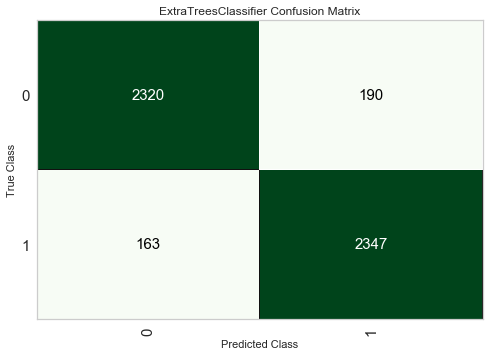

Wall time: 2.47 s


In [9]:
%%time

# How does it perform?
plot_model(estimator = et20, plot = 'confusion_matrix')

DoneNotice(2000)

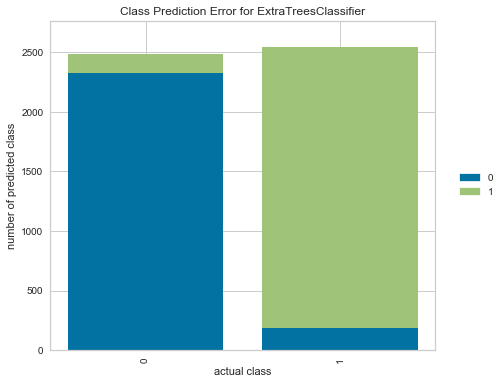

Wall time: 2.51 s


In [10]:
%%time

# How does the errors report look?
plot_model(estimator = et20, plot = 'error')

DoneNotice(2000)

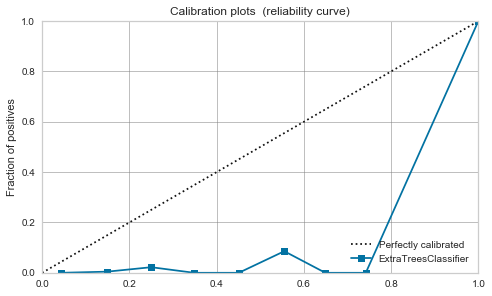

Wall time: 2.43 s


In [18]:
%%time

# Does "calibration" help? Step 1: plot the calibration:
plot_model(estimator = et20, plot = 'calibration')

DoneNotice(2000)

In [12]:
%%time

# Run calibration:
calibrated_et = calibrate_model(et20)

DoneNotice(2000)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.9206,0.9718,0.9027,0.9363,0.9192,0.8413
1,0.9488,0.9776,0.9352,0.9614,0.9481,0.8976
2,0.9223,0.9682,0.9060,0.9364,0.9209,0.8446
3,0.9308,0.9746,0.9214,0.9390,0.9301,0.8617
4,0.9291,0.9754,0.9128,0.9435,0.9279,0.8582
5,0.9291,0.9668,0.8991,0.9564,0.9269,0.8582
6,0.9368,0.9767,0.9369,0.9369,0.9369,0.8736
7,0.9368,0.9748,0.9232,0.9491,0.9360,0.8736
8,0.9436,0.9764,0.9334,0.9530,0.9431,0.8873
9,0.9436,0.9807,0.9352,0.9514,0.9432,0.8873


Wall time: 9min 12s


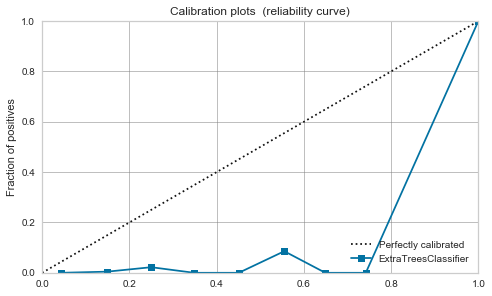

Wall time: 2.35 s


In [20]:
%%time

# Step 2: plot the new calibration and analyze
plot_model(estimator = et20, plot = 'calibration')

DoneNotice(2000)

In [21]:
%%time

# This function optimizes probability threshold for a trained model using custom cost function that can be defined using combination of True Positives, True Negatives, False Positives (also known as Type I error), and False Negatives (Type II error). This function returns a plot of optimized cost as a function of probability threshold between 0 to 100.
# Returns a plot of optimized cost as a function of probability threshold between 0 to 100.
optimize_threshold(
    estimator = et20
    , true_positive = 0
    , true_negative = 0
    , false_positive = 0
    , false_negative = 0
)

DoneNotice(2000)

Optimized Probability Threshold: 0.0 | Optimized Cost Function: 0
Wall time: 5.68 s


In [22]:
%%time

predict_model(
    estimator = et20
    , data=None # All features  used during training must be present in the new dataset.
    , probability_threshold=None # by default, 0.5
    , platform=None
    , authentication=None
)

DoneNotice(2000)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Extra Trees Classifier,0.988,0.9989,0.9957,0.9806,0.9881,0.976


Wall time: 2.45 s


In [23]:
%%time

# Learning Curve takes a long time
# Don't run this - run the individual reports instead
# evaluate_model(et20)

DoneNotice(2000)

Wall time: 2 s


In [13]:
%%time

# Finalize the model for production
finalize_model(et20)

DoneNotice(2000)

Wall time: 18.3 s


In [14]:
%%time

# Save it!
save_model(et20, '../models/et20200526_2010', verbose=True)

DoneNotice(2000)

Transformation Pipeline and Model Succesfully Saved
Wall time: 2.08 s
